In [1]:
import pickle
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data.dataset import random_split
import torch.optim as optim

from enc_dec_with_atten import cooling_model

In [2]:
def train(model, iterator, optimizer, criterion, clip):
    
    model.train()
    
    epoch_loss = 0
    
    for i, (src, trg) in enumerate(iterator):
        
        # src = batch.src
        # trg = batch.trg
        
        optimizer.zero_grad()
        
        output = model(src, trg)
        
        #trg = [trg len, batch size]
        #output = [trg len, batch size, output dim]
        
        output_dim = output.shape[-1]
        
        # output = output[1:].view(-1, output_dim)
        # trg = trg[1:].view(-1)
        
        #trg = [(trg len - 1) * batch size]
        #output = [(trg len - 1) * batch size, output dim]
        
        loss = criterion(output, trg)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for i, (src, trg) in enumerate(iterator):

            output = model(src, trg, 0) #turn off teacher forcing

            #trg = [trg len, batch size]
            #output = [trg len, batch size, output dim]

            output_dim = output.shape[-1]
            
            # output = output[1:].view(-1, output_dim)
            # trg = trg[1:].view(-1)

            #trg = [(trg len - 1) * batch size]
            #output = [(trg len - 1) * batch size, output dim]

            loss = criterion(output, trg)

            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator), output

In [3]:
class CustomDataset(Dataset):
    def __init__(self, data_input, data_output):

        super(CustomDataset, self).__init__()
        self.output_seq = data_output
        self.input_seq = data_input
        # self.transform = transform
        #self.target_transform = target_transform
        
    def __len__(self):
        return len(self.input_seq)
    
    
    def __getitem__(self, idx):
#        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        input_seq = self.input_seq[idx, :, :]
        output_seq = self.output_seq[idx, :, :]
        # if self.transform:
        #     image = self.transform(image)
        # if self.target_transform:
        #     label = self.target_transform(label)
        return input_seq, output_seq

In [4]:
model_config = torch.load(r'.\temp_data\GRU_based_atten_seq2seq.pt')

In [5]:
model_config.keys()

dict_keys(['epoch', 'model_state', 'enc_hid_dim', 'dec_hid_dim', 'dropout'])

In [6]:
config = {
    "enc_hid_dim": model_config['enc_hid_dim'],
    "dec_hid_dim": model_config['dec_hid_dim'],
    "dropout": model_config['dropout'],
    "data_dir":r'.\temp_data\public_data.pt',
    "model_type": 'GRU',
    "batch_size": 128,
    "n_epochs": 30,
    "device": torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
    "train_ratio": 0.9,
    'criterion': nn.MSELoss()
}

In [7]:
scaler = torch.load(config['data_dir'])['scaler']
train_data_X, train_data_Y, test_data_X, test_data_Y = torch.load(config['data_dir'])['data']

In [8]:
## configuration of training data
INPUT_DIM = train_data_X.shape[2]
OUTPUT_DIM = train_data_Y.shape[2]
BATCH_SIZE = 128
src_len = train_data_X.shape[1]
trg_len = train_data_Y.shape[1]

test_data = CustomDataset(test_data_X, test_data_Y)

test_dataloader = DataLoader(test_data, batch_size=len(test_data), shuffle=False)


In [9]:
### Step 4: Predict on testing data
model_new = cooling_model(INPUT_DIM, OUTPUT_DIM, config['device'], enc_hid_dim=config['enc_hid_dim'], dec_hid_dim=config['dec_hid_dim'],
                  dropout=config['dropout'], model_type=config['model_type'])
model_new.load_state_dict(model_config['model_state'])

test_loss, output = evaluate(model_new, test_dataloader, config['criterion'])

print('Error for testing data : %f'%test_loss)

Error for testing data : 0.015803


In [10]:
output.shape

torch.Size([2900, 24, 11])

In [11]:
## transverse scale
all_cooling = []
for i in range(output.shape[1]):
    print('%d th future hour prediction'%(i+1))
    predict_data = scaler.inverse_transform(output[:, i, :])
    actual_data = scaler.inverse_transform(test_data_Y[:, i, :])
    
    all_cooling.append([actual_data[:, -1], predict_data[:, -1]]) ### the position of the energy consumption is 

1 th future hour prediction
2 th future hour prediction
3 th future hour prediction
4 th future hour prediction
5 th future hour prediction
6 th future hour prediction
7 th future hour prediction
8 th future hour prediction
9 th future hour prediction
10 th future hour prediction
11 th future hour prediction
12 th future hour prediction
13 th future hour prediction
14 th future hour prediction
15 th future hour prediction
16 th future hour prediction
17 th future hour prediction
18 th future hour prediction
19 th future hour prediction
20 th future hour prediction
21 th future hour prediction
22 th future hour prediction
23 th future hour prediction
24 th future hour prediction


In [12]:
all_cooling

[[array([35.66030525, 37.4380756 , 28.50788027, ...,  5.19259719,
          2.1294871 ,  2.728889  ]),
  array([38.26379136, 32.43310238, 33.02120355, ..., 10.44805647,
         11.27814713,  8.26017482])],
 [array([37.4380756 , 28.50788027, 29.20938182, ...,  2.1294871 ,
          2.728889  ,  0.        ]),
  array([36.82816694, 31.49865744, 32.12710777, ..., 12.56758838,
         13.03753266,  6.60935059])],
 [array([28.50788027, 29.20938182, 33.43543564, ...,  2.728889  ,
          0.        ,  0.        ]),
  array([35.84332958, 31.02629041, 31.65291336, ..., 14.25354384,
         12.10755618,  4.59585357])],
 [array([29.20938182, 33.43543564, 29.38196293, ...,  0.        ,
          0.        ,  0.43214285]),
  array([34.93581466, 30.64162117, 31.3451354 , ..., 13.53417946,
         10.23803699,  3.83615425])],
 [array([33.43543564, 29.38196293, 24.64746598, ...,  0.        ,
          0.43214285,  0.        ]),
  array([34.1411974 , 30.40666325, 31.33145206, ..., 11.94518437,
   

In [13]:
all_cooling = np.array(all_cooling)

In [14]:
all_cooling.shape

(24, 2, 2900)

In [15]:
## 1-hour-ahead prediction error
all_cooling_1 = all_cooling[0, :, :]
all_cooling_1 = pd.DataFrame(all_cooling_1.T, columns=['actual', 'predict'])

In [16]:
all_cooling_1

,actual,predict
0,35.660305,38.263791
1,37.438076,32.433102
2,28.507880,33.021204
3,29.209382,27.719257
4,33.435436,28.265444
...,...,...
2895,3.325012,7.229697
2896,3.458767,9.732126
2897,5.192597,10.448056
2898,2.129487,11.278147


Text(0.5, 1.0, 'The prediction in the first 28 days')

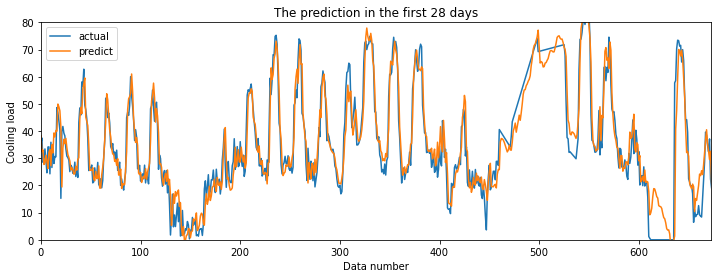

In [17]:
fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(111)
all_cooling_1.plot(ax=ax)
ax.set(xlim=[0, 24*28], ylim=[0, 80], xlabel='Data number', ylabel='Cooling load')
ax.set_title('The prediction in the first 28 days')

In [18]:
print('%d-hour-ahead prediction - RMSE = %f'%(1, np.sqrt(mean_squared_error(all_cooling_1['actual'], all_cooling_1['predict']))))
print('%d-hour-ahead prediction - MAE = %f'%(1, mean_absolute_error(all_cooling_1['actual'], all_cooling_1['predict'])))

1-hour-ahead prediction - RMSE = 6.653092
1-hour-ahead prediction - MAE = 4.561021


In [19]:
## 24-hour-ahead preidction
mean_rmse = []
mean_mae = []
mean_mape = []
for i in range(all_cooling.shape[2]):
    mean_rmse.append(np.sqrt(mean_squared_error(all_cooling[:, 0, i], all_cooling[:, 1, i])))
    mean_mae.append(mean_absolute_error(all_cooling[:, 0, i], all_cooling[:, 1, i]))
    mean_mape.append(mean_absolute_percentage_error(all_cooling[:, 0, i], all_cooling[:, 1, i]))

In [20]:
print('%d-hour-ahead prediction - RMSE = %f'%(24, np.mean(mean_rmse)))
print('%d-hour-ahead prediction - MAE = %f'%(24, np.mean(mean_mae)))

24-hour-ahead prediction - RMSE = 13.064277
24-hour-ahead prediction - MAE = 11.004915
